In [21]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
%matplotlib inline

In [22]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [23]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [24]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['fAX'] = gaussian_filter(df['AX'], window_length)
    df1['fAY'] = gaussian_filter(df['AY'], window_length)
    df1['fAZ'] = gaussian_filter(df['AZ'], window_length)

    df1['fGX'] = gaussian_filter(df['GX'], window_length)
    df1['fGY'] = gaussian_filter(df['GY'], window_length)
    df1['fGZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [25]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike = df_bike[3000:13000]
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike.head()

shape - (14413, 8)
shape - (10000, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,60002,0.946191,0.335965,-1.380772,-0.063095,-0.078720,0.035873,bike
1,60021,0.282677,0.677211,-0.592512,-0.114227,-0.141571,0.008179,bike
2,60041,0.541477,0.866996,1.060262,-0.052444,-0.141571,-0.037628,bike
3,60061,0.069439,0.456029,0.068076,0.149963,0.006500,-0.031235,bike
4,60082,0.005020,-0.462948,-1.091515,0.076462,-0.005219,-0.020584,bike


In [79]:
#data for car

acc_file = 'data/car/2018-08-17_16-43-04/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-43-04/Gyroscope.csv'

df_car = read_csv_file(acc_file, gyro_file, 'car')

print("shape -", df_car.shape)
df_car = df_car[1300:12000]
df_car.reset_index(drop = True, inplace = True)
print("shape -", df_car.shape)
df_car.head()

shape - (6646, 8)
shape - (5346, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,26000,1.310577,-0.599656,-2.653413,-0.030792,-0.118576,-0.002655,car
1,26020,0.001736,-1.469157,2.047003,-0.094711,0.188217,0.012268,car
2,26041,-0.361463,-0.839294,0.419466,0.088516,0.030563,0.010132,car
3,26061,1.720914,-0.621697,0.038787,-0.090454,-0.015244,-0.003723,car
4,26080,2.569507,-1.287929,-0.327906,-0.049973,-0.208054,-0.003723,car


Text(0,0.5,'Amplitude ($rad/s$)')

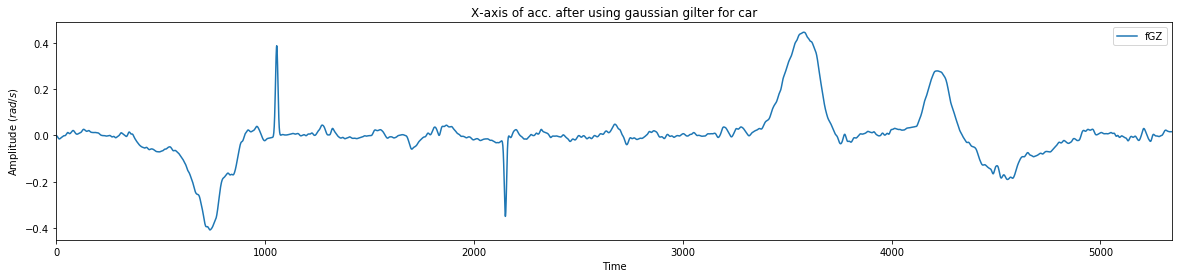

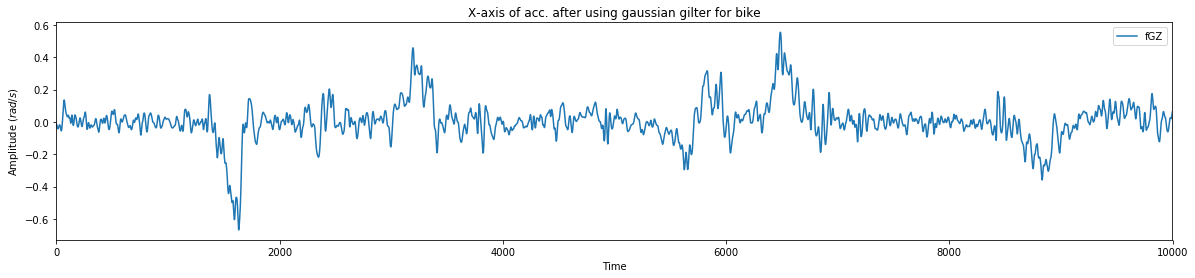

In [80]:
df_car_smooth = GaussianFilter(df_car, 5)
df_car_smooth['fAccMean'] = (df_car_smooth['fAX'] + df_car_smooth['fAY'] + df_car_smooth['fAZ'])/3
df_car_smooth['fGyroMean'] = (df_car_smooth['fGX'] + df_car_smooth['fGY'] + df_car_smooth['fGZ'])/3

df_car_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for car")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

df_bike_smooth = GaussianFilter(df_bike, 5)
df_bike_smooth['fAccMean'] = (df_bike_smooth['fAX'] + df_bike_smooth['fAY'] + df_bike_smooth['fAZ'])/3
df_bike_smooth['fGyroMean'] = (df_bike_smooth['fGX'] + df_bike_smooth['fGY'] + df_bike_smooth['fGZ'])/3
df_bike_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for bike")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

In [81]:
def segmentation(df):
    N_TIME_STEPS = 350
    N_FEATURES = 1
    step = 20
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['fGZ'].values[i: i + N_TIME_STEPS]
        gy = df['fGY'].values[i: i + N_TIME_STEPS]
    #     label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]

        segments.append([gz,gy])
    #     labels.append(label)
    return segments

In [82]:
car_segments = segmentation(df_car_smooth)
np.array(car_segments).shape

(250, 2, 350)

In [83]:
len(car_segments)

250

In [84]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

In [85]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [86]:
dist_fun = manhattan_distances
loss= []
for i in range(len(car_segments)):
    x = car_segments[i][0]
    y = car_segments[202][0]
#     xx = pd.Series(x)
#     xx.plot()
    dist, cost, acc, path = dtw(x, y, dist_fun)
    loss.append(dist)
    print(i,"=>",dist)


0 => 0.0504861524241
1 => 0.0498791348568
2 => 0.0475354995985
3 => 0.0467735326199
4 => 0.0466301395718
5 => 0.0465877529504
6 => 0.0465480374937
7 => 0.0491072708571
8 => 0.0510198462454
9 => 0.0533242315105
10 => 0.0544060755012
11 => 0.0549636041357
12 => 0.0552015331154
13 => 0.0560929200071
14 => 0.0578511726605
15 => 0.0607494192355
16 => 0.0656104448085
17 => 0.0712234206426
18 => 0.0826357876433
19 => 0.103803645272
20 => 0.125043461338
21 => 0.136399469312
22 => 0.142522945815
23 => 0.146138170839
24 => 0.149080531078
25 => 0.151915420377
26 => 0.153885780599
27 => 0.154127713035
28 => 0.154360058769
29 => 0.154573707382
30 => 0.153458450852
31 => 0.145992020066
32 => 0.137609072052
33 => 0.130938040585
34 => 0.123516835712
35 => 0.112605434387
36 => 0.0731592964142
37 => 0.0593402323531
38 => 0.0475799376815
39 => 0.0376375495619
40 => 0.0310530883807
41 => 0.0252058580949
42 => 0.0197914223144
43 => 0.0146224706966
44 => 0.0116694325436
45 => 0.0104176989443
46 => 0.0109099

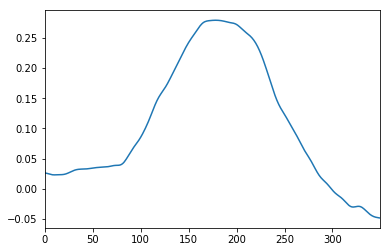

In [87]:
x = car_segments[202][0]
xx = pd.Series(x)
xx.plot()

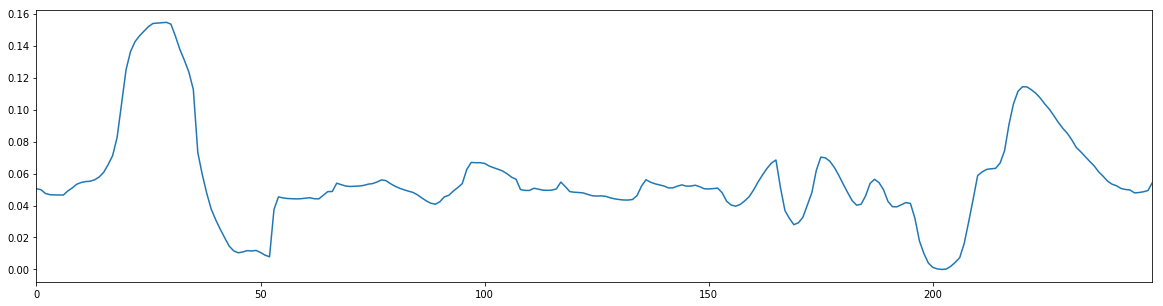

In [89]:

loss_series = pd.Series(loss)
loss_series.plot(figsize=(20,5))